# Imports

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T 

In [2]:
%matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: 
    from IPython import display

# Network

In [3]:
class DQN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=64)   
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=2)
            
    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

# Experience and Memory

In [4]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):  # returns a boolean
        return len(self.memory) >= batch_size

# Agent & Strategy

In [5]:
class Agent():
    def __init__(self, strategy, num_actions):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            return torch.Tensor([random.randrange(self.num_actions)]) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax().unsqueeze(0).to(torch.float32) # exploit   
                       
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):  # Exponential Decay
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

# Helper Functions

In [6]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    t1 = torch.cat(batch.state, 0)
    t2 = torch.cat(batch.action, 0)
    t3 = torch.cat(batch.reward, 0)
    t4 = torch.cat(batch.next_state, 0)
    return (t1,t2,t3,t4)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
    
def plot(moving_avg_period, values, title):
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.figure(2)     
    plt.clf()  
    
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(range(1,1+len(values)), values, label='Per Episode Return') 
    plt.plot(range(1,1+len(moving_avg)), moving_avg, label='Moving Average') 
    plt.legend(loc=4)
    
    plt.pause(0.001)
    print(f'Episode: {len(values)} \n{moving_avg_period} Episode Moving Avg: {moving_avg[-1]}')
    if is_ipython: 
        display.clear_output(wait=True)

# Hyper Paramaters

In [7]:
batch_size = 64
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.0001
target_update = 10
memory_size = 5000
lr = 0.001
num_episodes = 1500

In [8]:
env = gym.make('CartPole-v0')
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay) 
agent = Agent(strategy, env.action_space.n)
memory = ReplayMemory(memory_size)

obs_space_n, = env.observation_space.shape
policy_net = DQN(obs_space_n)
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
target_net = DQN(obs_space_n)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

# Training

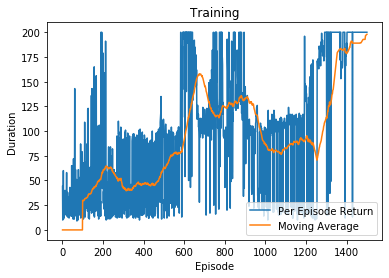

Episode: 1500 
100 Episode Moving Avg: 197.9199981689453


In [9]:
episode_durations = []  # acts as total return of an episode; allows us to plot our progress

for episode in range (num_episodes):
    state = torch.Tensor(env.reset()).unsqueeze(0) 
    
    for timestep in count():
        action = agent.select_action(state, policy_net).unsqueeze(0)
        next_state, reward, done, info = env.step(int(action.item()))
        next_state = torch.Tensor(next_state).unsqueeze(0)
        
        if done:
            reward = torch.Tensor([[0]])
        else:
            reward = torch.as_tensor(reward, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
                experiences = memory.sample(batch_size)
                states, actions, rewards, next_states = extract_tensors(experiences)

                # Q values
                current_q_values = policy_net(states).gather(dim=1, index=actions.to(torch.int64))
                next_q_values = target_net(next_states).max(dim=1)[0].detach().unsqueeze(1) # max returns both max and index
                target_q_values = (next_q_values * gamma) + rewards
                
                # Updating Policy Network
                loss = F.mse_loss(current_q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()    
                
        if done:
            episode_durations.append(timestep+1) # +1 because timestep starts at 0 
            if (episode+1) % 100 == 0:
                plot(100, episode_durations, "Training")
            break      
    
    # Updating Target Network
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
env.close()

# Saving 

In [10]:
torch.save(policy_net.state_dict(), "CartPoleNN.pth")

# Testing Model

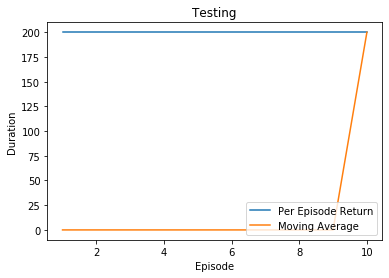

Episode: 10 
10 Episode Moving Avg: 200.0


In [11]:
test_env = gym.make('CartPole-v0')
test_obs_space_n, = test_env.observation_space.shape 

test_policy = DQN(test_obs_space_n)
test_policy.load_state_dict(torch.load("CartPoleNN.pth")) 
test_policy.eval()

test_episodes = 10
test_durations = []

for episode in range(test_episodes):
    state = torch.Tensor(test_env.reset()).unsqueeze(0) 
    
    for timestep in count():
        with torch.no_grad():
                action = test_policy(state).argmax().unsqueeze(0).to(torch.float32)     
        next_state, reward, done, info = test_env.step(int(action.item()))
        next_state = torch.Tensor(next_state).unsqueeze(0)
        state = next_state
        test_env.render() 
        
        if done:
            test_durations.append(timestep+1) 
            plot(test_episodes, test_durations, "Testing")
            break    
            
test_env.close()